## Load and predictions
Get the load that is going to be tested and its predictions

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.models import load_model

# get an absolute path to the directory that contains parent files
project_dir = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..")))

from barazmoon.twitter import twitter_workload_generator

from experiments.utils.constants import PROJECT_PATH, LSTM_PATH, LSTM_INPUT_SIZE

23/23 [==============================] - 0s 5ms/step


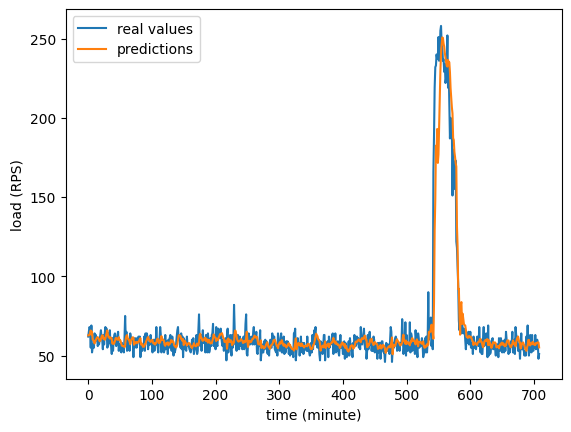

In [6]:
fig_path = os.path.join(
    PROJECT_PATH, "prediction-modules", "lstm-module", "lstm_prediction.png"
)

# TODO HERE fix in the easiest way

model = load_model(LSTM_PATH)
# workload = twitter_workload_generator('1-2')
workload = twitter_workload_generator("2:0:0:0-2:2:0:0")
workload = list(filter(lambda x: x != 0, workload))  # for removing missing hours
hour = 60 * 60
day = hour * 24
# test_idx = 18 * day
test_idx = 0
# test_data = workload[test_idx:test_idx + 2 * hour]
test_data = workload


def get_x_y(data):
    """
    For each 60 seconds it taeks the max of last 60 seconds
    and returns an output with length of len(data)/60 that
    each entry is the maximum rps in each aggregated 60 seconds
    x: series of max of every 1 minute
    y: target of the 10 minutes
    """
    x = []
    y = []
    history_seconds = 120
    step = 10
    for i in range(0, len(data) - history_seconds, step):
        t = data[i : i + history_seconds]
        for j in range(0, len(t), step):
            x.append(max(t[j : j + step]))
        y.append(max(data[i + history_seconds : i + history_seconds + step]))
    return x, y


test_x, test_y = get_x_y(test_data)

test_x = tf.convert_to_tensor(np.array(test_x).reshape((-1, 12, 1)), dtype=tf.int32)
prediction = model.predict(test_x)
plt.plot(list(range(len(test_y))), list(test_y), label="real values")
plt.plot(list(range(len(test_y))), list(prediction), label="predictions")
plt.xlabel("time (minute)")
plt.ylabel("load (RPS)")
plt.legend()
plt.savefig(fig_path)

In [7]:
workload = twitter_workload_generator("1:0:0-1:2:0")
len(workload)

7201

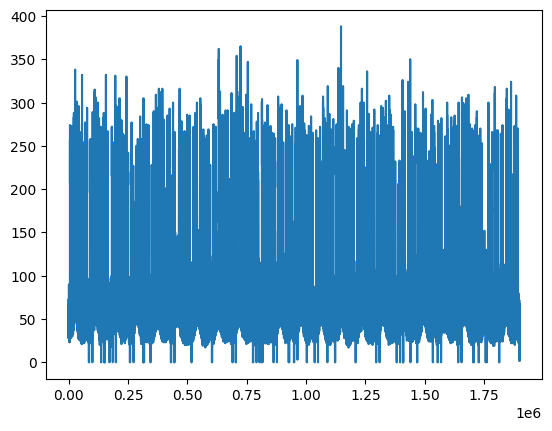

In [8]:
workload = twitter_workload_generator("1:0:0-23:0:0")
plt.plot(workload)

In [9]:
# %matplotlib widget
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.widgets import Slider

# fig, ax = plt.subplots()
# plt.subplots_adjust(bottom=0.25)

# workload = twitter_workload_generator("1:0:0-23:0:0")
# t = np.arange(0.0, len(workload), 1)
# workload = workload
# (l,) = plt.plot(t, workload)
# window_size = 12 * 3600
# plt.axis([0, window_size, 0, max(workload)])

# axcolor = "lightgoldenrodyellow"
# axpos = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=axcolor)

# spos = Slider(axpos, "Pos", 0.1, len(workload) - 10.0)


# def update(val):
#     pos = spos.val
#     ax.axis([pos, pos + window_size, 0, max(workload)])
#     fig.canvas.draw_idle()


# spos.on_changed(update)

# plt.show()

In [10]:
from tensorflow.keras.models import load_model

from experiments.utils.constants import LSTM_PATH


def get_x_y(data):
    x = []
    y = []
    input_length = 12
    data = data[:]
    for i in range(input_length):
        data.insert(0, data[0])
    for i in range(0, len(data) - input_length):
        x.extend(data[i : i + input_length])
        y.append(data[i + input_length])
    x = np.array(x)
    print("shapes")
    print(x.shape)
    print(len(y))
    return tf.convert_to_tensor(x.reshape((-1, input_length, 1)), dtype=tf.float32), y


lstm = load_model(LSTM_PATH)

In [11]:
from statsmodels.tsa.arima.model import ARIMA


def get_arima_prediction(data):
    preds = []
    data = np.array(data).reshape((-1, 12))
    for history in data:
        model = ARIMA(history, order=(1, 0, 0))
        model_fit = model.fit()
        pred = int(max(model_fit.forecast(steps=2)))  # max
        preds.append(pred)
    return preds

In [12]:
lstm_plot_kwargs = {"label": "LSTM", "marker": "*"}
arima_plot_kwargs = {"label": "ARIMA", "marker": "|"}

# Bursty Workload

### 10 minutes

shapes
(7200,)
600
19/19 [==============================] - 0s 4ms/step


/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


start: 1301400


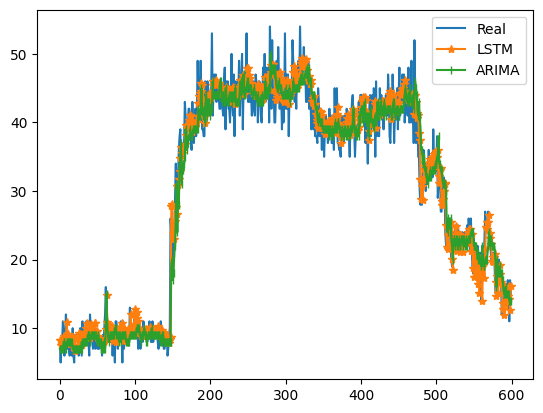

In [13]:
# Plot subpart based on above
%matplotlib inline
start = 1296000
duration = 10 * 60  # 10 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if max(selected_workload) - min(selected_workload) > 30:
        break
    start += duration


plt.plot(list(range(len(selected_workload))), selected_workload, label="Real")
x, _ = get_x_y(selected_workload)
plt.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
arima = get_arima_prediction(x)
plt.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
plt.legend()
print(f"start: {start}")  # 1301400
print(f"end: {start+duration}")

### 20 minutes

shapes
(14400,)
1200
38/38 [==============================] - 0s 4ms/step


/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


start: 1301160
end: 1302360


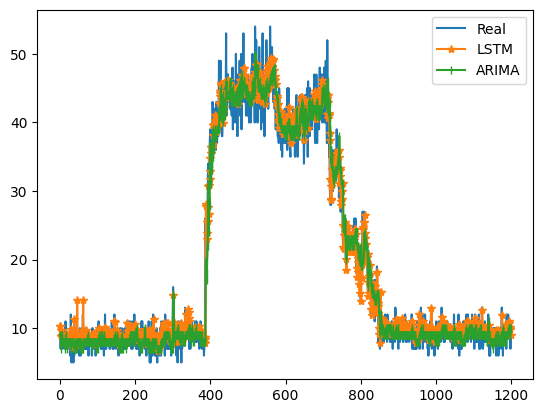

In [14]:
# Plot subpart based on above
%matplotlib inline
start = 1296000
duration = 20 * 60  # 10 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) > 30
        and abs(selected_workload[0] - selected_workload[-200]) < 5
        and abs(selected_workload[0] - selected_workload[500]) > 30
    ):
        break
    start += 60 * 2


plt.plot(list(range(len(selected_workload))), selected_workload, label="Real")
x, _ = get_x_y(selected_workload)
plt.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
arima = get_arima_prediction(x)
plt.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
plt.legend()
print(f"start: {start}")  # 1301160
print(f"end: {start+duration}")

# Steady Low

### 10 minutes

shapes
(7200,)
600
19/19 [==============================] - 0s 4ms/step


/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


start: 1296000


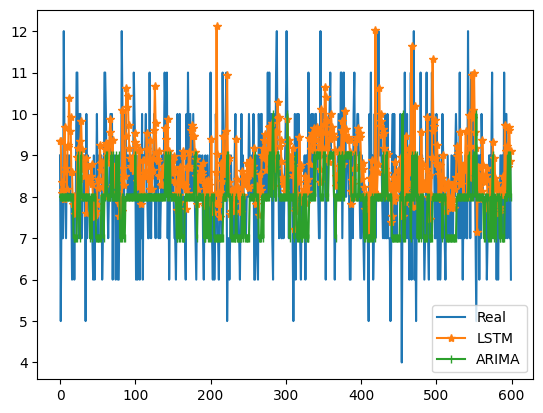

In [15]:
# Plot subpart based on above
%matplotlib inline
start = 1296000
duration = 10 * 60  # 10 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) < 9
        and max(selected_workload) < 20
    ):
        break
    start += duration


plt.plot(list(range(len(selected_workload))), selected_workload, label="Real")
x, _ = get_x_y(selected_workload)
plt.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
arima = get_arima_prediction(x)
plt.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
plt.legend()
print(f"start: {start}")  # 1296000
print(f"end: {start+duration}")

### 20 minutes

shapes
(14400,)
1200
38/38 [==============================] - 0s 4ms/step


/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


start: 1299600


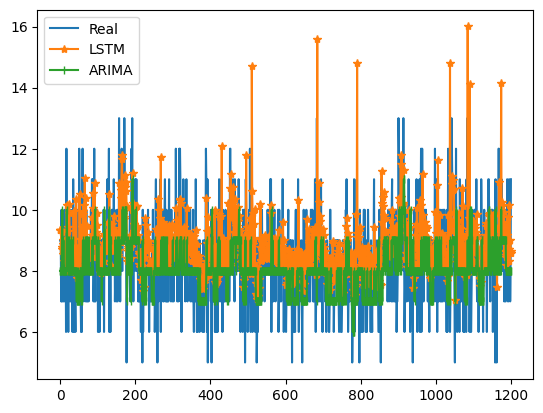

In [16]:
# Plot subpart based on above
%matplotlib inline
start = 1296000
duration = 20 * 60  # 10 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) < 9
        and max(selected_workload) < 20
    ):
        break
    start += duration


plt.plot(list(range(len(selected_workload))), selected_workload, label="Real")
x, _ = get_x_y(selected_workload)
plt.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
arima = get_arima_prediction(x)
plt.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
plt.legend()
print(f"start: {start}")  # 1299600
print(f"end: {start+duration}")

# Steady High

### 10 minutes

shapes
(7200,)
600
19/19 [==============================] - 0s 4ms/step


/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


start: 1768800


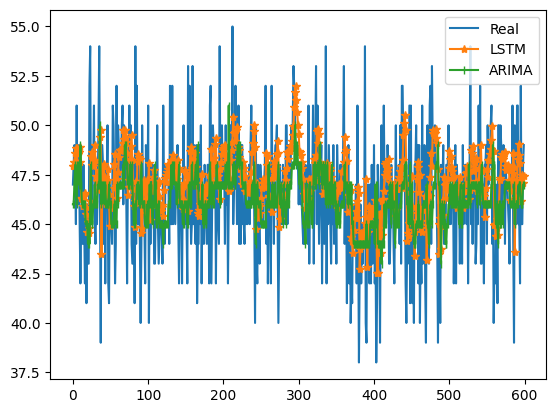

In [17]:
# Plot subpart based on above
%matplotlib inline
start = 1296000
duration = 10 * 60  # 10 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) < 18
        and min(selected_workload) > 30
    ):
        break
    start += duration


plt.plot(list(range(len(selected_workload))), selected_workload, label="Real")
x, _ = get_x_y(selected_workload)
plt.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
arima = get_arima_prediction(x)
plt.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
plt.legend()
print(f"start: {start}")  # 1768800
print(f"end: {start+duration}")

### 20 minutes

In [18]:
# Plot subpart based on above
%matplotlib inline
start = 1296000
duration = 10 * 60  # 10 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) < 18
        and min(selected_workload) > 30
    ):
        break
    start += duration

selected_workload = selected_workload * 2
plt.plot(list(range(len(selected_workload))), selected_workload, label="Real")
x, _ = get_x_y(selected_workload)
plt.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
arima = get_arima_prediction(x)
plt.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
plt.legend()
print(f"start: {start}")  # 1768800
print(f"end: {start+duration}")

shapes
(14400,)
1200
38/38 [==============================] - 0s 4ms/step


/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Fluctuating

shapes
(14400,)
1200
38/38 [==============================] - 0s 4ms/step


/home/cc/miniconda3/envs/central/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


start: 1301400 | start2: 1308600


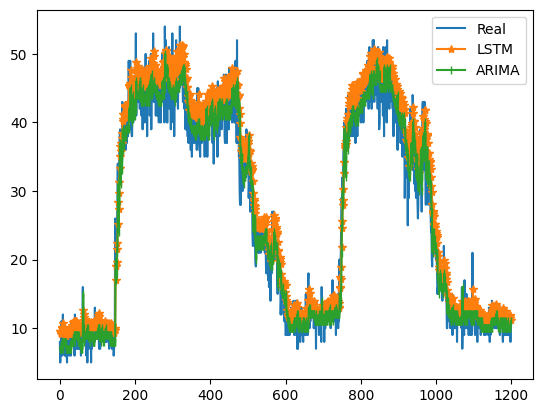

In [ ]:
# Plot subpart based on above
%matplotlib inline
start = 1296000
duration = 10 * 60  # 10 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if max(selected_workload) - min(selected_workload) > 30:
        break
    start += duration

start2 = start + duration
while True:
    selected_workload2 = workload[start2 : start2 + duration]
    if max(selected_workload2) - min(selected_workload2) > 30:
        break
    start2 += duration
selected_workload = selected_workload + selected_workload2

plt.plot(list(range(len(selected_workload))), selected_workload, label="Real")
x, _ = get_x_y(selected_workload)
plt.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
arima = get_arima_prediction(x)
plt.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
plt.legend()
plt.savefig(
    os.path.abspath("") + "/trace-figures/fluctuating.png",
    dpi=600,
    format="png",
    bbox_inches="tight",
    pad_inches=0,
)
print(f"start: {start} | start2: {start2}")  # start: 1301400 | start2: 1308600